In [1]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import torch

from IPython.display import display
from ipywidgets import widgets
from sklearn.metrics import roc_curve, auc


from src.consts import IN_COLAB, MAX_PADDING_SLICES
from src.dataset.han_oars_dataset import HaNOarsDataset
from src.helpers.calc_dsc import calc_dsc
from src.helpers.threshold_calc_helpers import get_threshold_info_df
from src.model_and_training.unet_architecture import UNet

torch.manual_seed(20)

# Evaluation

## Chossing model

In [2]:
folders = []
for folder in os.scandir('models'):
    if folder.is_dir() and not folder.name.startswith('.'):
        folders.append(folder.name)
sorted(folders)

['20200423-005539_3d_unet',
 '20200426-202445_3d_unet',
 '20200505-205420_3d_unet',
 '20200505-224539_3d_unet',
 '20200509-152114_3d_unet',
 '20200510-012205_3d_unet',
 '20200510-131237_3d_unet']

In [3]:
dice_loss_folder = "20200510-131237_3d_unet"

train_indices = [1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 15, 16, 18, 19, 21, 22, 23, 24, 25, 29, 31, 32, 33, 34, 35, 36, 37, 38, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50]
valid_indices = [7, 14, 20, 26, 39]
test_indices = [17, 27, 28, 30, 40]
model_folder = dice_loss_folder

In [5]:
model_folder_path = f'models/{model_folder}'
max_epoch = 0
checkpoint_file_name = ''
for file in os.scandir(model_folder_path):
    epoch = int(file.name.split('.pkl')[0].split('_')[-1])
    if epoch > max_epoch:
        max_epoch = epoch
        checkpoint_file_name = file.name

model_checkpoint_path = f'{model_folder_path}/{checkpoint_file_name}'
print(model_checkpoint_path)

models/20200510-131237_3d_unet/checkpoint_20200510-131237_3d_unet_epoch_100.pkl


## Loading model and dataset

In [6]:
with torch.no_grad():
    device = torch.device('cuda')
    state = torch.load(model_checkpoint_path, map_location=device)

    ### PARAMS
    # model
    in_channels = 16

    model = UNet(in_channels=in_channels).to(device)
    model.load_state_dict(state['state_dict'], )
    model.eval()
    
# Dataset
dataset_size = 50
if IN_COLAB:
    print('COLAB using 4x dataset')
    dataset = HaNOarsDataset('/content/drive/My Drive/data/HaN_OAR_eyes+lens_shrink4x_padded160', dataset_size)
else:
    if torch.cuda.is_available():
        print('CUDA using 4x dataset')
        dataset = HaNOarsDataset('./data/HaN_OAR_eyes+lens_shrink4x_padded160', dataset_size)
    else:
        print('CPU using 16x dataset')
        dataset = HaNOarsDataset('./data/HaN_OAR_eyes+lens_shrink16x_padded160', dataset_size)

max output channels 256
CUDA using 4x dataset


## Calculating DSC for different thresholds

finding best threshold in training data

starting calc dsc per threshold
done train
done valid
done test
----------- Sorted by threshold value


0.00    0.000254
0.01    0.904876
0.02    0.903263
0.03    0.901921
0.04    0.901528
          ...   
0.96    0.870977
0.97    0.869285
0.98    0.866479
0.99    0.862528
1.00    0.003208
Length: 101, dtype: float64

----------- Sorted by average DSC


0.00    0.000254
1.00    0.003208
0.99    0.862528
0.98    0.866479
0.97    0.869285
          ...   
0.05    0.901194
0.04    0.901528
0.03    0.901921
0.02    0.903263
0.01    0.904876
Length: 101, dtype: float64

----------- Curve


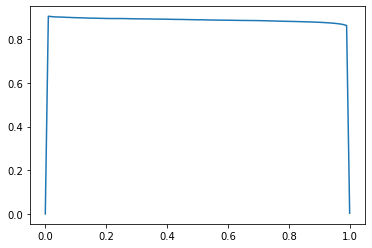

----------- Best Threshold
dsc on train: 0.9048763647428076, threshold 0.01
----------- Eval
--valid--


index
1     0.953184
6     0.935135
18    0.931330
34    0.826087
46    0.930451
Name: thres_rescaled_dsc_0.01, dtype: float64

--test--


index
2     0.941250
28    0.957831
39    0.950680
40    0.919598
43    0.911483
Name: thres_rescaled_dsc_0.01, dtype: float64

Results DSC: train 0.9048763647428079 valid 0.9152374424357358 test 0.9361685681896628


In [7]:
info_df = get_threshold_info_df(model, dataset, device, train_indices, valid_indices, test_indices)

# getting mean dsc for each treshold
train_tmp_df = info_df[info_df['is_train']]
mean_train_tmp_df = train_tmp_df.mean().drop(['index', 'dsc', 'rescaled_dsc', 'is_train', 'is_valid', 'is_test']).copy()
mean_train_tmp_df.index = mean_train_tmp_df.index.str.split('_').map(lambda x: eval(x[-1]))

print('----------- Sorted by threshold value')
display(mean_train_tmp_df)
print()

print('----------- Sorted by average DSC')
display(mean_train_tmp_df.sort_values())
print()

print('----------- Curve')
mean_train_tmp_df.plot()
plt.show()
print()

print('----------- Best Threshold')
best_threshold = mean_train_tmp_df.index[mean_train_tmp_df.argmax()]
print()

print(f'dsc on train: {mean_train_tmp_df.max()}, threshold {best_threshold}')
info_df = info_df.set_index('index')
info_df.index = info_df.index + 1

# final results with best treshold
print('----------- Eval')
best_threshold_column = f'thres_rescaled_dsc_{best_threshold}'
train_tmp = info_df[info_df['is_train']][best_threshold_column]
valid_tmp = info_df[info_df['is_valid']][best_threshold_column]
# test_tmp = info_df[info_df['is_test']][best_threshold_column]
print('--valid--')
display(valid_tmp)
# print('--test--')
# display(test_tmp)

print(f'Results DSC: train {train_tmp.mean()} valid {valid_tmp.mean()}')

In [13]:
y_true = []
y_scores = []
for i in range(len(dataset)):
    data, label = dataset[i]
    y_true.append(label)
    y_scores.append(rescaled_preds[i])
y_true = np.array(y_true)
y_scores = np.array(y_scores)

def g(dataset_index):
    print(f'showing dataset {dataset_index}')
    fpr, tpr, thresholds = roc_curve(dataset[dataset_index-1][1].flatten(), rescaled_preds[dataset_index-1].flatten())
    # fpr, tpr, thresholds = roc_curve(y_true.flatten(), y_scores.flatten())
    print(fpr, tpr)
    roc_auc = auc(fpr, tpr)

    print("\nArea under the ROC curve: " + str(roc_auc))
    plt.figure()
    plt.plot(fpr, tpr,'-',label='Area Under the Curve (AUC = %0.4f)' % roc_auc)
    plt.title('ROC curve')
    plt.xlabel("FPR (False Positive Rate)")
    plt.ylabel("TPR (True Positive Rate)")
    plt.legend(loc="lower right")
    plt.show()

datasetSlider = widgets.IntSlider(min=1, max=50, step=1, value=33)
ui1 = widgets.VBox([widgets.HBox([datasetSlider])])
out = widgets.interactive_output(g, { 'dataset_index': datasetSlider })
display(ui1, out)

Output()

## Evaluating best threshold

In [9]:
info_df[[best_threshold_column, 'is_train']].sort_values(by=best_threshold_column)

,thres_rescaled_dsc_0.01,is_train
index,,
15,0.627494,True
25,0.806849,True
34,0.826087,False
21,0.827778,True
30,0.836700,True
38,0.837349,True
44,0.846547,True
5,0.861217,True
36,0.876204,True


In [10]:
def g(dataset_i, custom_thresh):
    print(f'showing dataset {dataset_i}')
    data, label = dataset[dataset_i-1]
    data_input = torch.from_numpy(np.array([data])).to(device).float()

    # batch, channel, slices, x, y
    prediction = model(data_input)[0].cpu().detach().numpy()[0]
    rescaled_pred = (prediction - prediction.min()) / prediction.max()
    thres_rescaled_pred = (rescaled_pred > best_threshold) * 1
    # TODO Remove
    thres_rescaled_pred = (rescaled_pred >= custom_thresh) * 1

    print(f'data min {data.min()} max {data.max()}')
    print(f'label min {label.min()} max {label.max()}')
    print(f'prediction min {prediction.min()} max {prediction.max()}')
    print(f'norm_pred min {rescaled_pred.min()} max {rescaled_pred.max()}')
    print(f'dsc {calc_dsc(label, prediction)}')
    print(f'rescaled dsc {calc_dsc(label, rescaled_pred)}')
    print(f'thres_rescaled dsc {calc_dsc(label, thres_rescaled_pred)}')
    
    inverted_label = 1 - label
    tp = (label * thres_rescaled_pred).sum()
    fp = (inverted_label * thres_rescaled_pred).sum()
    tpr = tp / label.sum()
    fpr = fp / inverted_label.sum()
    print(f'label sum {label.sum()}, thres_rescaled_pred sum {thres_rescaled_pred.sum()}')
    print(f'TP {tp}, FP {fp}, TPR {tpr}, FPR {fpr}')

    def f(a):
        inter_img = (label[a] & thres_rescaled_pred[a])
        inter_img = np.expand_dims(inter_img, axis=-1).astype(np.uint8)
        inter_img = cv2.cvtColor(inter_img, cv2.COLOR_GRAY2BGR) * 255
        inter_img[:, :, 0] = 0
        inter_img[:, :, 2] = 0

        bad_img = label[a] - thres_rescaled_pred[a]
        bad_img = np.expand_dims(bad_img, axis=-1).astype(np.uint8)
        bad_img = cv2.cvtColor(bad_img, cv2.COLOR_GRAY2BGR) * 255
        bad_img[:, :, 1] = 0
        bad_img[:, :, 2] = 0

        bad_img2 = thres_rescaled_pred[a] - label[a]
        bad_img2 = np.expand_dims(bad_img2, axis=-1).astype(np.uint8)
        bad_img2 = cv2.cvtColor(bad_img2, cv2.COLOR_GRAY2BGR) * 255
        bad_img2[:, :, 0] = 0
        bad_img2[:, :, 1] = 0

        plt.figure(figsize=(30, 30))

        plt.subplot(3, 3, 1)
        plt.title('input')
        plt.imshow(data[0][a], cmap="gray")
        
        plt.subplot(3, 3, 2)
        plt.title('label')
        plt.imshow(label[a], cmap="gray")
        
        plt.subplot(3, 3, 4)
        plt.title('prediction')
        plt.imshow(prediction[a], cmap="gray", vmin=0, vmax=1)
        
        plt.subplot(3, 3, 3)
        plt.title('prediction')
        tmp = inter_img + bad_img + bad_img2
        plt.legend(handles=[mpatches.Patch(color=(0, 1, 0), label="Interception"), mpatches.Patch(color=(1, 0, 0), label="Label - Prediction"), mpatches.Patch(color=(0, 0, 1), label="Prediction - Label")])
        plt.imshow(tmp)
                
        plt.subplot(3, 3, 5)
        plt.title('rescaled prediction')
        plt.imshow(rescaled_pred[a], cmap="gray", vmin=0, vmax=1)
        
        plt.subplot(3, 3, 6)
        plt.title('rescaled and threshold prediction')
        plt.imshow(thres_rescaled_pred[a], cmap="gray")
        
        plt.subplot(3, 3, 7)
        plt.title('inverted label')
        plt.imshow(inverted_label[a], cmap="gray")
        
        plt.subplot(3, 3, 8)
        plt.title('inverted label * threshold prediction')
        plt.imshow(inverted_label[a] * thres_rescaled_pred[a], cmap="gray")

        plt.show()

    sliceSlider = widgets.IntSlider(min=0, max=MAX_PADDING_SLICES-1, step=1, value=101)
    ui2 = widgets.VBox([widgets.HBox([sliceSlider])])
    out = widgets.interactive_output(f, { 'a': sliceSlider })
    display(ui2, out)

    
datasetSlider = widgets.IntSlider(min=1, max=50, step=1, value=33)
customThresSlider = widgets.FloatSlider(min=0, max=1, step=0.05, value=0.5)
ui1 = widgets.VBox([widgets.HBox([datasetSlider, customThresSlider])])
out = widgets.interactive_output(g, { 'dataset_i': datasetSlider, 'custom_thresh': customThresSlider })
display(ui1, out)

Output()